In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import os
import sys


root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from utils.utils import *
from utils.constant import *

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
# Set a seed for reproducibility
np.random.seed(42)


In [2]:
file_path = get_absolute_path(
    'small_set_sales_by_date_sku_zip.csv',
    'data',
    PROJECT_BASE_DIR
)

data = pd.read_csv(file_path)

In [3]:
data.head(3)

,ORDER_PLACED_DTTM,PRODUCT_PART_NUMBER,CUSTOMER_ADDRESS_ZIP,PRODUCT_CATEGORY_LEVEL1,PRODUCT_CATEGORY_LEVEL2,PRODUCT_CATEGORY_LEVEL3,PRODUCT_MERCH_CLASSIFICATION1,PRODUCT_MERCH_CLASSIFICATION2,PRODUCT_MERCH_CLASSIFICATION3,NET_SALES,UNITS
0,2022-11-22,100112,1028.0,Cat,Food,Dry Food,Consumables,Core Food,Dry Food,0.00,1.0
1,2022-11-22,100112,2152.0,Cat,Food,Dry Food,Consumables,Core Food,Dry Food,6.47,1.0
2,2022-11-22,100112,2813.0,Cat,Food,Dry Food,Consumables,Core Food,Dry Food,6.47,1.0


In [4]:
### Basic Information about the Datasets

# Display basic information about the dataset
print(data.info())

# Display summary statistics for numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7417129 entries, 0 to 7417128
Data columns (total 11 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   ORDER_PLACED_DTTM              object 
 1   PRODUCT_PART_NUMBER            int64  
 2   CUSTOMER_ADDRESS_ZIP           float64
 3   PRODUCT_CATEGORY_LEVEL1        object 
 4   PRODUCT_CATEGORY_LEVEL2        object 
 5   PRODUCT_CATEGORY_LEVEL3        object 
 6   PRODUCT_MERCH_CLASSIFICATION1  object 
 7   PRODUCT_MERCH_CLASSIFICATION2  object 
 8   PRODUCT_MERCH_CLASSIFICATION3  object 
 9   NET_SALES                      float64
 10  UNITS                          float64
dtypes: float64(3), int64(1), object(7)
memory usage: 622.5+ MB
None
       PRODUCT_PART_NUMBER  CUSTOMER_ADDRESS_ZIP     NET_SALES         UNITS
count         7.417129e+06          7.410835e+06  7.417128e+06  7.417128e+06
mean          1.469925e+05          4.690795e+04  3.953494e+01  1.782263e+00
std           3

In [5]:
data.columns

Index(['ORDER_PLACED_DTTM', 'PRODUCT_PART_NUMBER', 'CUSTOMER_ADDRESS_ZIP',
       'PRODUCT_CATEGORY_LEVEL1', 'PRODUCT_CATEGORY_LEVEL2',
       'PRODUCT_CATEGORY_LEVEL3', 'PRODUCT_MERCH_CLASSIFICATION1',
       'PRODUCT_MERCH_CLASSIFICATION2', 'PRODUCT_MERCH_CLASSIFICATION3',
       'NET_SALES', 'UNITS'],
      dtype='object')

In [6]:
print(data.groupby('PRODUCT_CATEGORY_LEVEL1')['UNITS'].sum())
print(data.groupby('PRODUCT_CATEGORY_LEVEL1')['NET_SALES'].sum())

print(data.groupby('PRODUCT_MERCH_CLASSIFICATION3')['UNITS'].sum())
print(data.groupby('PRODUCT_MERCH_CLASSIFICATION3')['NET_SALES'].sum())


print(data.groupby(['PRODUCT_CATEGORY_LEVEL1', 'PRODUCT_MERCH_CLASSIFICATION3'])['UNITS'].sum())
print(data.groupby(['PRODUCT_CATEGORY_LEVEL1', 'PRODUCT_MERCH_CLASSIFICATION3'])['NET_SALES'].sum())



PRODUCT_CATEGORY_LEVEL1
Cat         7893614.0
Dog         1428346.0
Pharmacy    3897312.0
Name: UNITS, dtype: float64
PRODUCT_CATEGORY_LEVEL1
Cat         1.943853e+08
Dog         9.301145e+07
Pharmacy    5.838943e+06
Name: NET_SALES, dtype: float64
PRODUCT_MERCH_CLASSIFICATION3
Dry Food                      9202220.0
Flea Combs & Tick Removers      51645.0
Infection Care                3897312.0
Poop Scoopers                   13135.0
Test Kits                       54960.0
Name: UNITS, dtype: float64
PRODUCT_MERCH_CLASSIFICATION3
Dry Food                      2.809750e+08
Flea Combs & Tick Removers    2.112785e+05
Infection Care                5.838943e+06
Poop Scoopers                 2.845482e+05
Test Kits                     5.926006e+06
Name: NET_SALES, dtype: float64
PRODUCT_CATEGORY_LEVEL1  PRODUCT_MERCH_CLASSIFICATION3
Cat                      Dry Food                         7889415.0
                         Flea Combs & Tick Removers           500.0
                         

In [26]:
# All product_part_numbers of MC3 == 'Dry Food'
id_list = data.loc[data['PRODUCT_MERCH_CLASSIFICATION3'] == 'Dry Food', 'PRODUCT_PART_NUMBER'].unique()

# Specify the number of IDs you want to randomly select
num_ids_to_select = 5

# Randomly select IDs
randomly_selected_ids = np.random.choice(id_list, size=num_ids_to_select, replace=False)

print(randomly_selected_ids)

[175534 125176 145466 144079 207660]


## 1. Time Series Analysis

- Visualize the time series of 'NET_SALES' and 'UNITS' over the given period
- Check for seasonality, trends, and unusual patterns

In [8]:
# Convert 'ORDER_PLACED_DTTM' to datetime
data['ORDER_PLACED_DTTM'] = pd.to_datetime(data['ORDER_PLACED_DTTM'])

# Set 'ORDER_PLACED_DTTM' as the index for time series analysis
data.set_index('ORDER_PLACED_DTTM', inplace=True)

#### Population Level Time Series

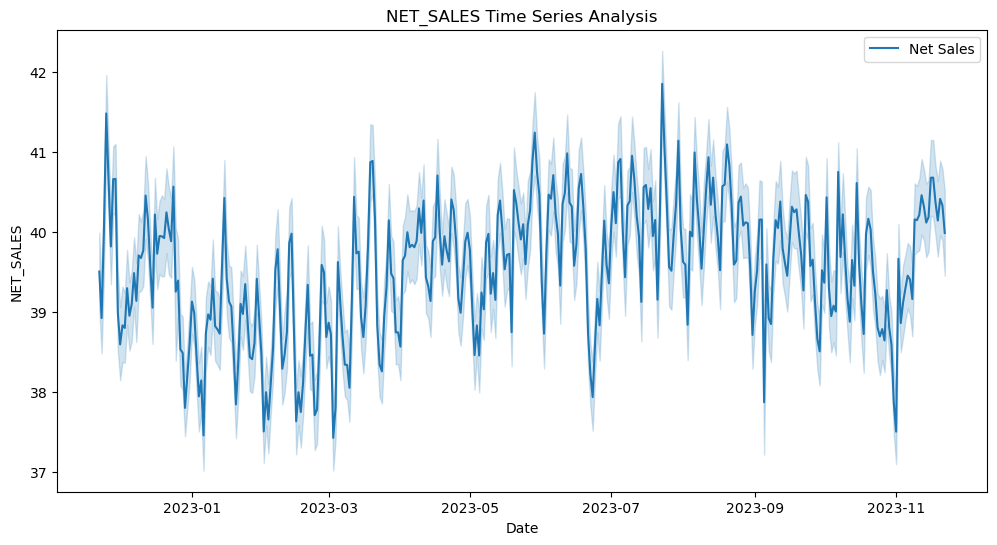

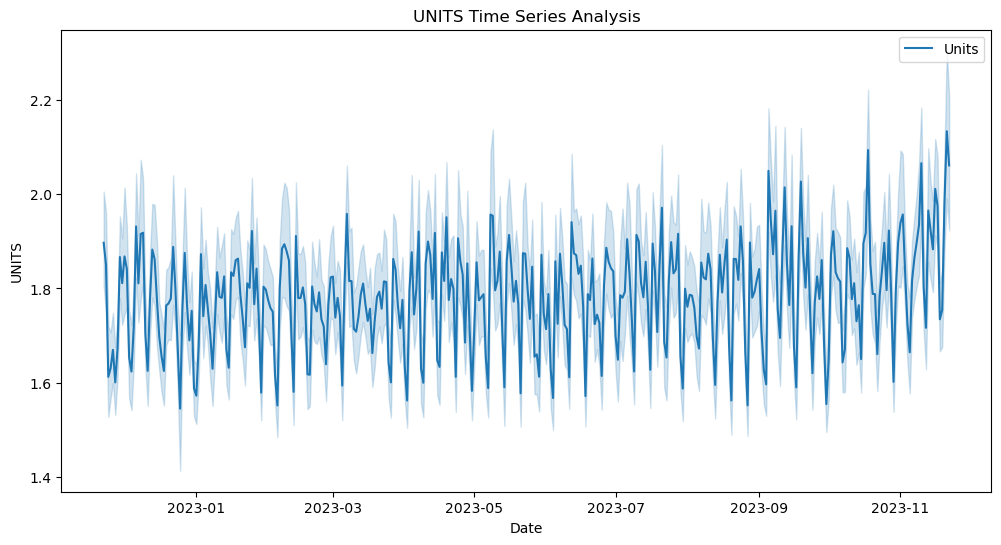

In [9]:
# Population level

plt.figure(figsize=(12, 6))
sns.lineplot(data=data['NET_SALES'], label='Net Sales')
plt.title('NET_SALES Time Series Analysis')
plt.xlabel('Date')
plt.ylabel('NET_SALES')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=data['UNITS'], label='Units')
plt.title('UNITS Time Series Analysis')
plt.xlabel('Date')
plt.ylabel('UNITS')
plt.legend()
plt.show()


#### Segment the Data Based on PRODUCT_CATEGORY_LEVEL3 and PRODUCT_CATEGORY_LEVEL1

In [10]:
segment_group_data = data.groupby(['ORDER_PLACED_DTTM', 'PRODUCT_CATEGORY_LEVEL1', 'PRODUCT_CATEGORY_LEVEL3'])[['NET_SALES', 'UNITS']].sum().reset_index()

# Convert 'ORDER_PLACED_DTTM' to datetime
segment_group_data['ORDER_PLACED_DTTM'] = pd.to_datetime(segment_group_data['ORDER_PLACED_DTTM'])

# Set 'ORDER_PLACED_DTTM' as the index for time series analysis
segment_group_data.set_index('ORDER_PLACED_DTTM', inplace=True)

# Combine 'PRODUCT_CATEGORY_LEVEL1' and 'PRODUCT_CATEGORY_LEVEL3' into a new column
segment_group_data['SEGMENT'] = segment_group_data['PRODUCT_CATEGORY_LEVEL1'] + ' - ' + segment_group_data['PRODUCT_CATEGORY_LEVEL3']

# Convert the index to datetime
segment_group_data.index = pd.to_datetime(segment_group_data.index)

# Only keep columns I need
segment_group_data = segment_group_data[['SEGMENT', 'NET_SALES', 'UNITS']]


In [11]:

segment_group_data

,SEGMENT,NET_SALES,UNITS
ORDER_PLACED_DTTM,,,
2022-11-22,Cat - Dry Food,486078.63512,20578.0
2022-11-22,Cat - Flea Combs & Tick Removers,9.98000,3.0
2022-11-22,Cat - Test Kits,250.55000,14.0
2022-11-22,Dog - Dry Food,218262.93549,3400.0
2022-11-22,Dog - Flea Combs & Tick Removers,542.61000,127.0
...,...,...,...
2023-11-22,Dog - Dry Food,173574.53000,2547.0
2023-11-22,Dog - Flea Combs & Tick Removers,410.03000,87.0
2023-11-22,Dog - Poop Scoopers,390.81000,17.0


In [40]:
# save data
saved_segment_group_data = segment_group_data
saved_segment_group_data_file_path = get_absolute_path(
    'segment_group_data.csv',
    'data/_small_set_sales_by_date_sku_zip',
    PROJECT_BASE_DIR
)

saved_segment_group_data.to_csv(saved_segment_group_data_file_path)

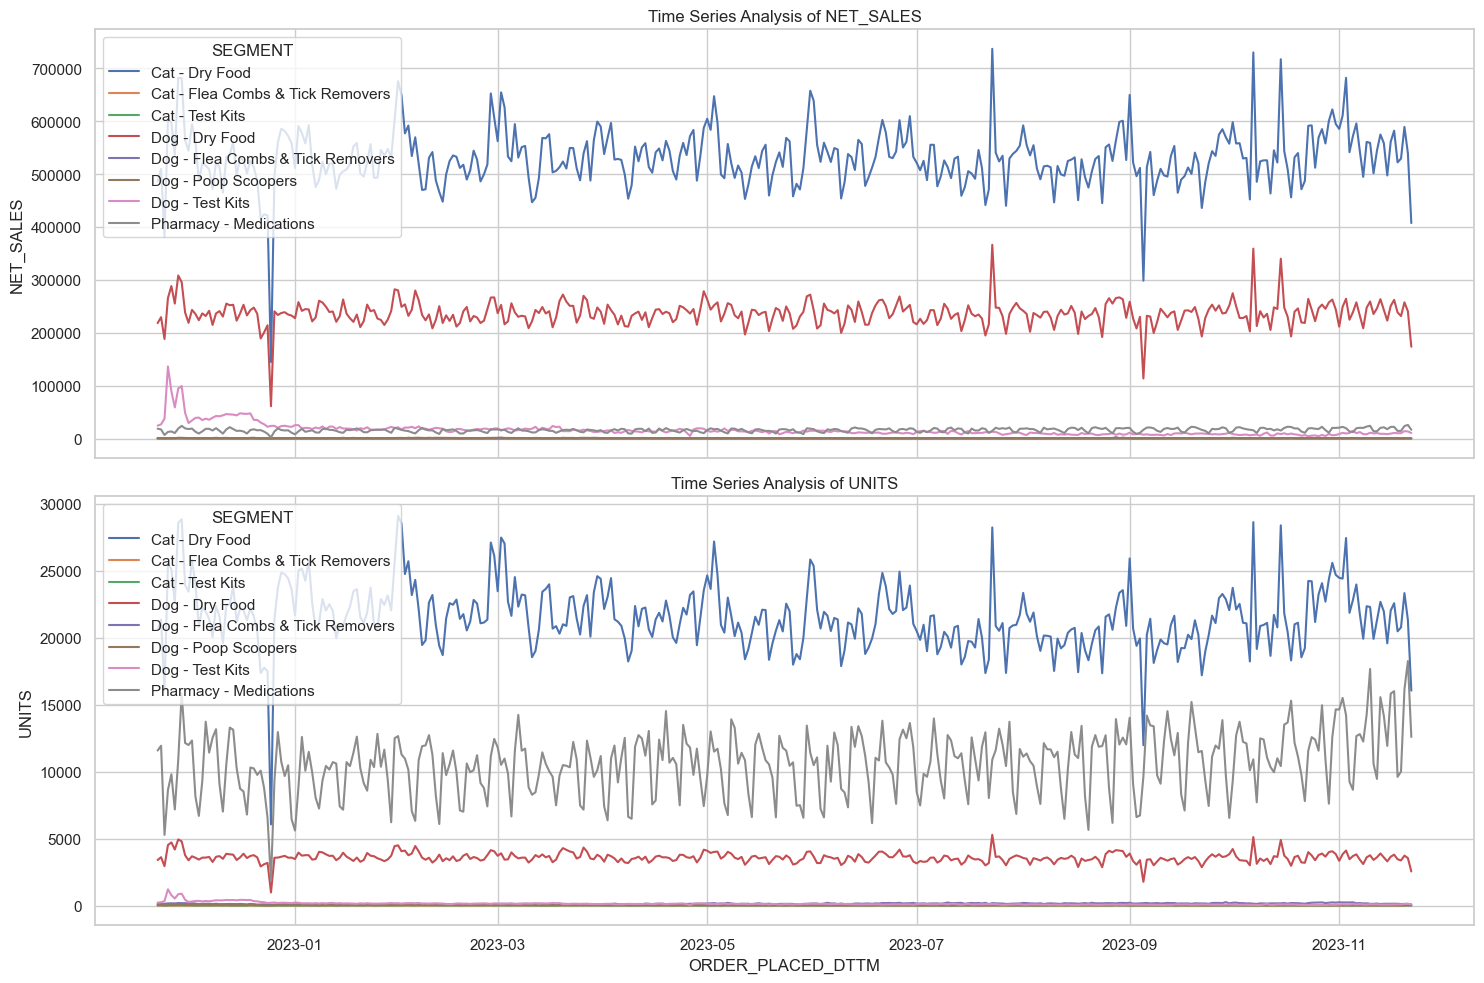

In [12]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Plotting NET_SALES and UNITS in separate subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Time Series Analysis of NET_SALES
sns.lineplot(x=segment_group_data.index, y='NET_SALES', hue='SEGMENT', data=segment_group_data, ax=axes[0])
axes[0].set_title('Time Series Analysis of NET_SALES')
axes[0].set_ylabel('NET_SALES')

# Time Series Analysis of UNITS
sns.lineplot(x=segment_group_data.index, y='UNITS', hue='SEGMENT', data=segment_group_data, ax=axes[1])
axes[1].set_title('Time Series Analysis of UNITS')
axes[1].set_xlabel('ORDER_PLACED_DTTM')
axes[1].set_ylabel('UNITS')

# Adjust the layout for better visualization
plt.tight_layout()
plt.show()

Time series analysis over the `segment_group_data` for
- trends
- seasibaluty
- residuals

We want to perform the time series decomposition at each segment level, we should iterate through each segment and apply the decomposition separately. 


In [13]:
# Initialize empty DataFrames to store results
trend_by_segment = pd.DataFrame()
seasonal_by_segment = pd.DataFrame()
residual_by_segment = pd.DataFrame()

# Add a small constant to avoid zero values for each segment
small_constant = 1e-6

# Iterate through each segment and perform time series decomposition
for _segment, _data in segment_group_data.groupby('SEGMENT'):
    net_sales = _data['NET_SALES'] + small_constant
    result = seasonal_decompose(net_sales, model='multiplicative', period=7)
    
    trend_by_segment[_segment] = result.trend
    seasonal_by_segment[_segment] = result.seasonal
    residual_by_segment[_segment] = result.resid

In [14]:
trend_by_segment

,Cat - Dry Food,Cat - Flea Combs & Tick Removers,Cat - Test Kits,Dog - Dry Food,Dog - Flea Combs & Tick Removers,Dog - Poop Scoopers,Dog - Test Kits,Pharmacy - Medications
ORDER_PLACED_DTTM,,,,,,,,
2022-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-25,542388.847494,NaN,285.631430,250435.324617,617.215244,865.676458,66826.338244,13949.481730
2022-11-26,570250.710458,9.968572,318.441430,261491.351375,647.950958,912.677887,77510.519830,14710.600715
...,...,...,...,...,...,...,...,...
2023-11-18,545744.846091,NaN,149.635715,243396.930001,598.098572,448.087144,10797.048572,20010.147144
2023-11-19,532892.167148,NaN,149.974287,236344.714287,565.182858,440.730001,11123.145715,19833.881430
2023-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
seasonal_by_segment

,Cat - Dry Food,Cat - Flea Combs & Tick Removers,Cat - Test Kits,Dog - Dry Food,Dog - Flea Combs & Tick Removers,Dog - Poop Scoopers,Dog - Test Kits,Pharmacy - Medications
ORDER_PLACED_DTTM,,,,,,,,
2022-11-22,1.000648,1.018352,1.132689,1.006696,1.009450,0.966073,0.963862,1.167668
2022-11-23,1.030242,0.987072,1.049560,0.997172,1.030672,1.058223,0.936495,1.104973
2022-11-24,1.020480,0.839084,1.045732,0.984664,0.995226,0.985596,0.956529,1.098174
2022-11-25,0.981835,NaN,0.864225,0.944948,1.043924,0.929763,1.015259,1.072299
2022-11-26,0.964332,0.988965,0.865566,0.981736,0.928579,0.881093,1.049022,0.798143
...,...,...,...,...,...,...,...,...
2023-11-18,0.964332,1.096017,0.864225,0.981736,0.928579,0.881093,1.049022,0.798143
2023-11-19,0.977888,0.955606,0.865566,1.034950,0.955647,1.053351,1.081945,0.670995
2023-11-20,1.024575,1.018352,0.945294,1.049835,1.036502,1.125901,0.996888,1.087746


In [16]:
residual_by_segment

,Cat - Dry Food,Cat - Flea Combs & Tick Removers,Cat - Test Kits,Dog - Dry Food,Dog - Flea Combs & Tick Removers,Dog - Poop Scoopers,Dog - Test Kits,Pharmacy - Medications
ORDER_PLACED_DTTM,,,,,,,,
2022-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-25,1.132984,NaN,1.194046,1.122306,0.992106,1.026533,2.007915,0.839656
2022-11-26,1.085934,1.009274,1.075601,1.122795,1.147570,0.994506,1.099457,1.143165
...,...,...,...,...,...,...,...,...
2023-11-18,0.991996,NaN,1.118630,0.997943,1.090907,0.901176,0.886720,0.899315
2023-11-19,1.015535,NaN,0.364602,0.946361,1.022875,1.062439,0.838073,1.090121
2023-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


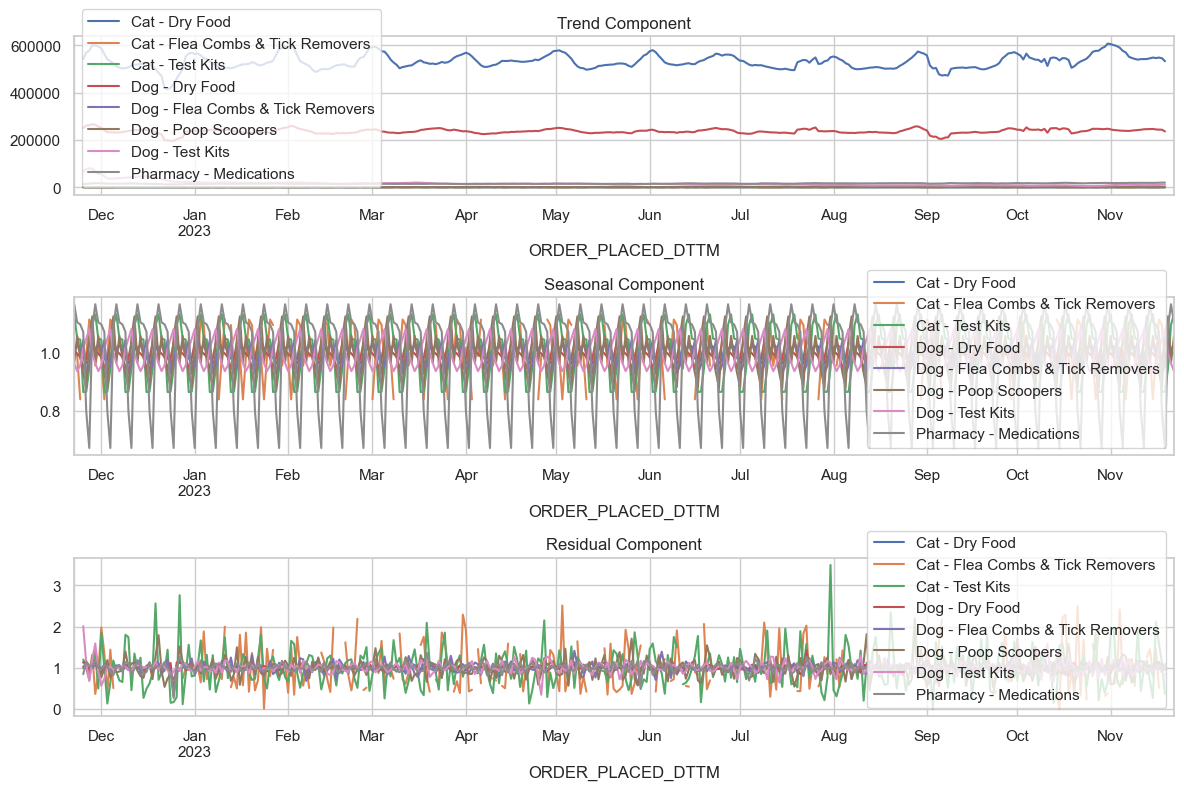

In [17]:
# Plot the decomposed components for all segments
plt.figure(figsize=(12, 8))

# Plot trend for all segments
plt.subplot(3, 1, 1)
trend_by_segment.plot(ax=plt.gca())
plt.title('Trend Component')

# Plot seasonal for all segments
plt.subplot(3, 1, 2)
seasonal_by_segment.plot(ax=plt.gca())
plt.title('Seasonal Component')

# Plot residual for all segments
plt.subplot(3, 1, 3)
residual_by_segment.plot(ax=plt.gca())
plt.title('Residual Component')

plt.tight_layout()
plt.show()

#### Generate a Subset DataFrame for Randomly Selected IDs

In [28]:
subset_data = data[data['PRODUCT_PART_NUMBER'].isin(randomly_selected_ids)][['PRODUCT_PART_NUMBER', 'NET_SALES', 'UNITS']]


In [31]:
subset_data.PRODUCT_PART_NUMBER.unique()

array([125176, 144079, 145466, 175534, 207660])

In [32]:
subset_data.head(3)

,PRODUCT_PART_NUMBER,NET_SALES,UNITS
ORDER_PLACED_DTTM,,,
2022-11-22,125176,39.88,1.0
2022-11-22,125176,44.83,1.0
2022-11-23,125176,41.98,1.0


In [41]:
# save data
saved_subset_data = subset_data
saved_subset_data_file_path = get_absolute_path(
    'subset_data.csv',
    'data/_small_set_sales_by_date_sku_zip',
    PROJECT_BASE_DIR
)

saved_subset_data.to_csv(saved_subset_data_file_path)

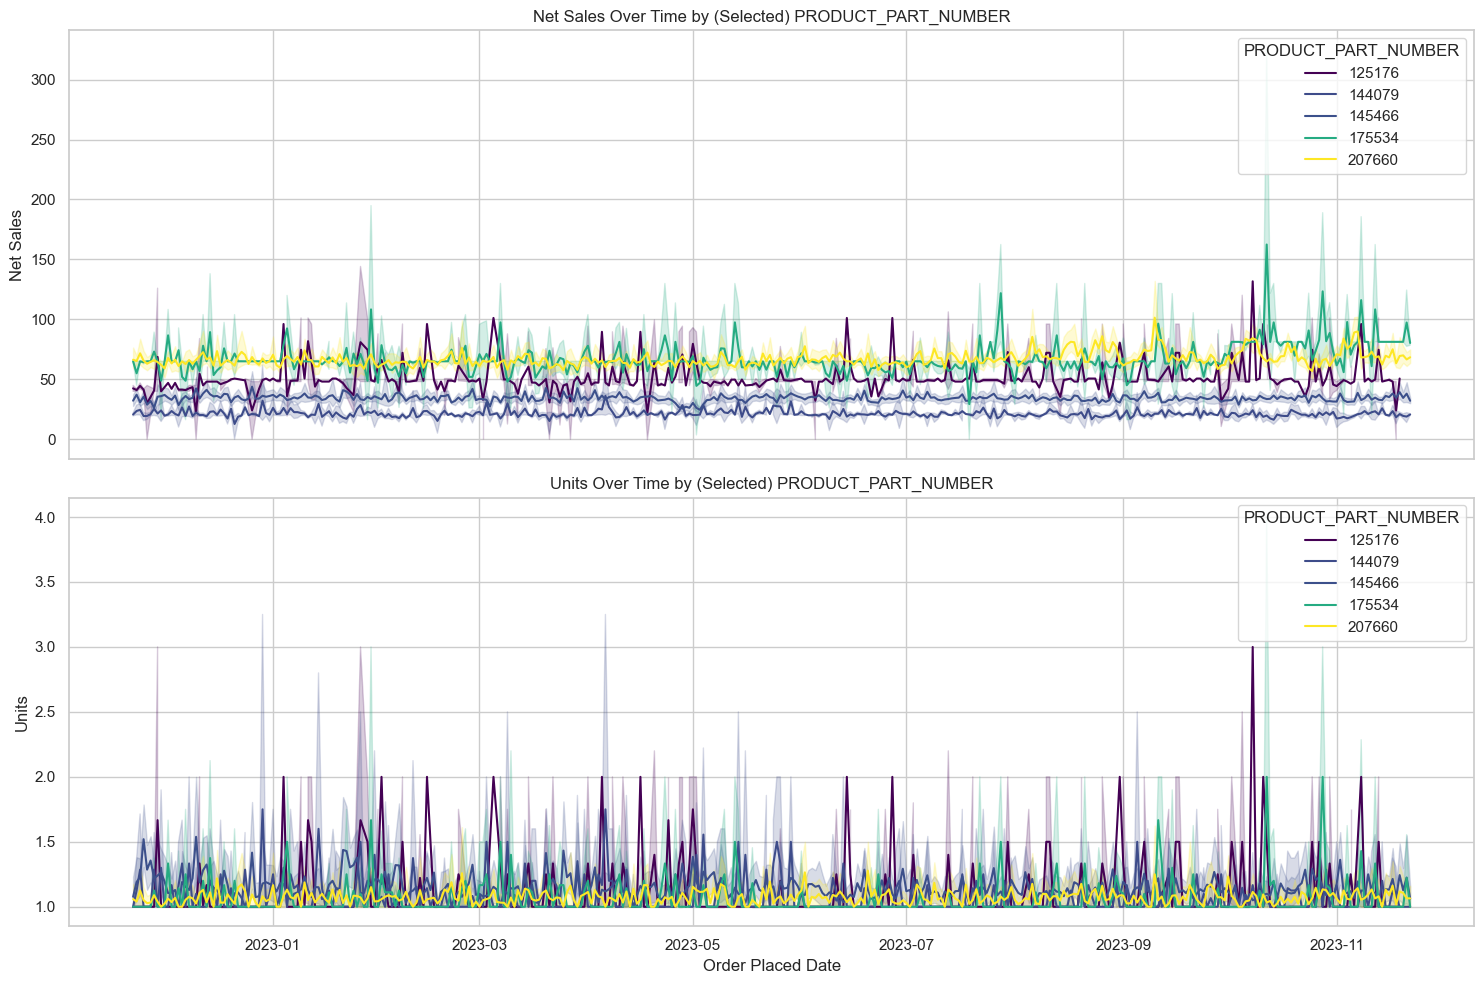

In [33]:
# Time Series Visualization
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

# Plot Net Sales
sns.lineplot(x=subset_data.index, y=subset_data['NET_SALES'], hue=subset_data['PRODUCT_PART_NUMBER'], ax=axes[0], palette='viridis')
axes[0].set_title('Net Sales Over Time by (Selected) PRODUCT_PART_NUMBER')
axes[0].set_ylabel('Net Sales')

# Plot Units
sns.lineplot(x=subset_data.index, y=subset_data['UNITS'], hue=subset_data['PRODUCT_PART_NUMBER'], ax=axes[1], palette='viridis')
axes[1].set_title('Units Over Time by (Selected) PRODUCT_PART_NUMBER')
axes[1].set_xlabel('Order Placed Date')
axes[1].set_ylabel('Units')

plt.tight_layout()
plt.show()

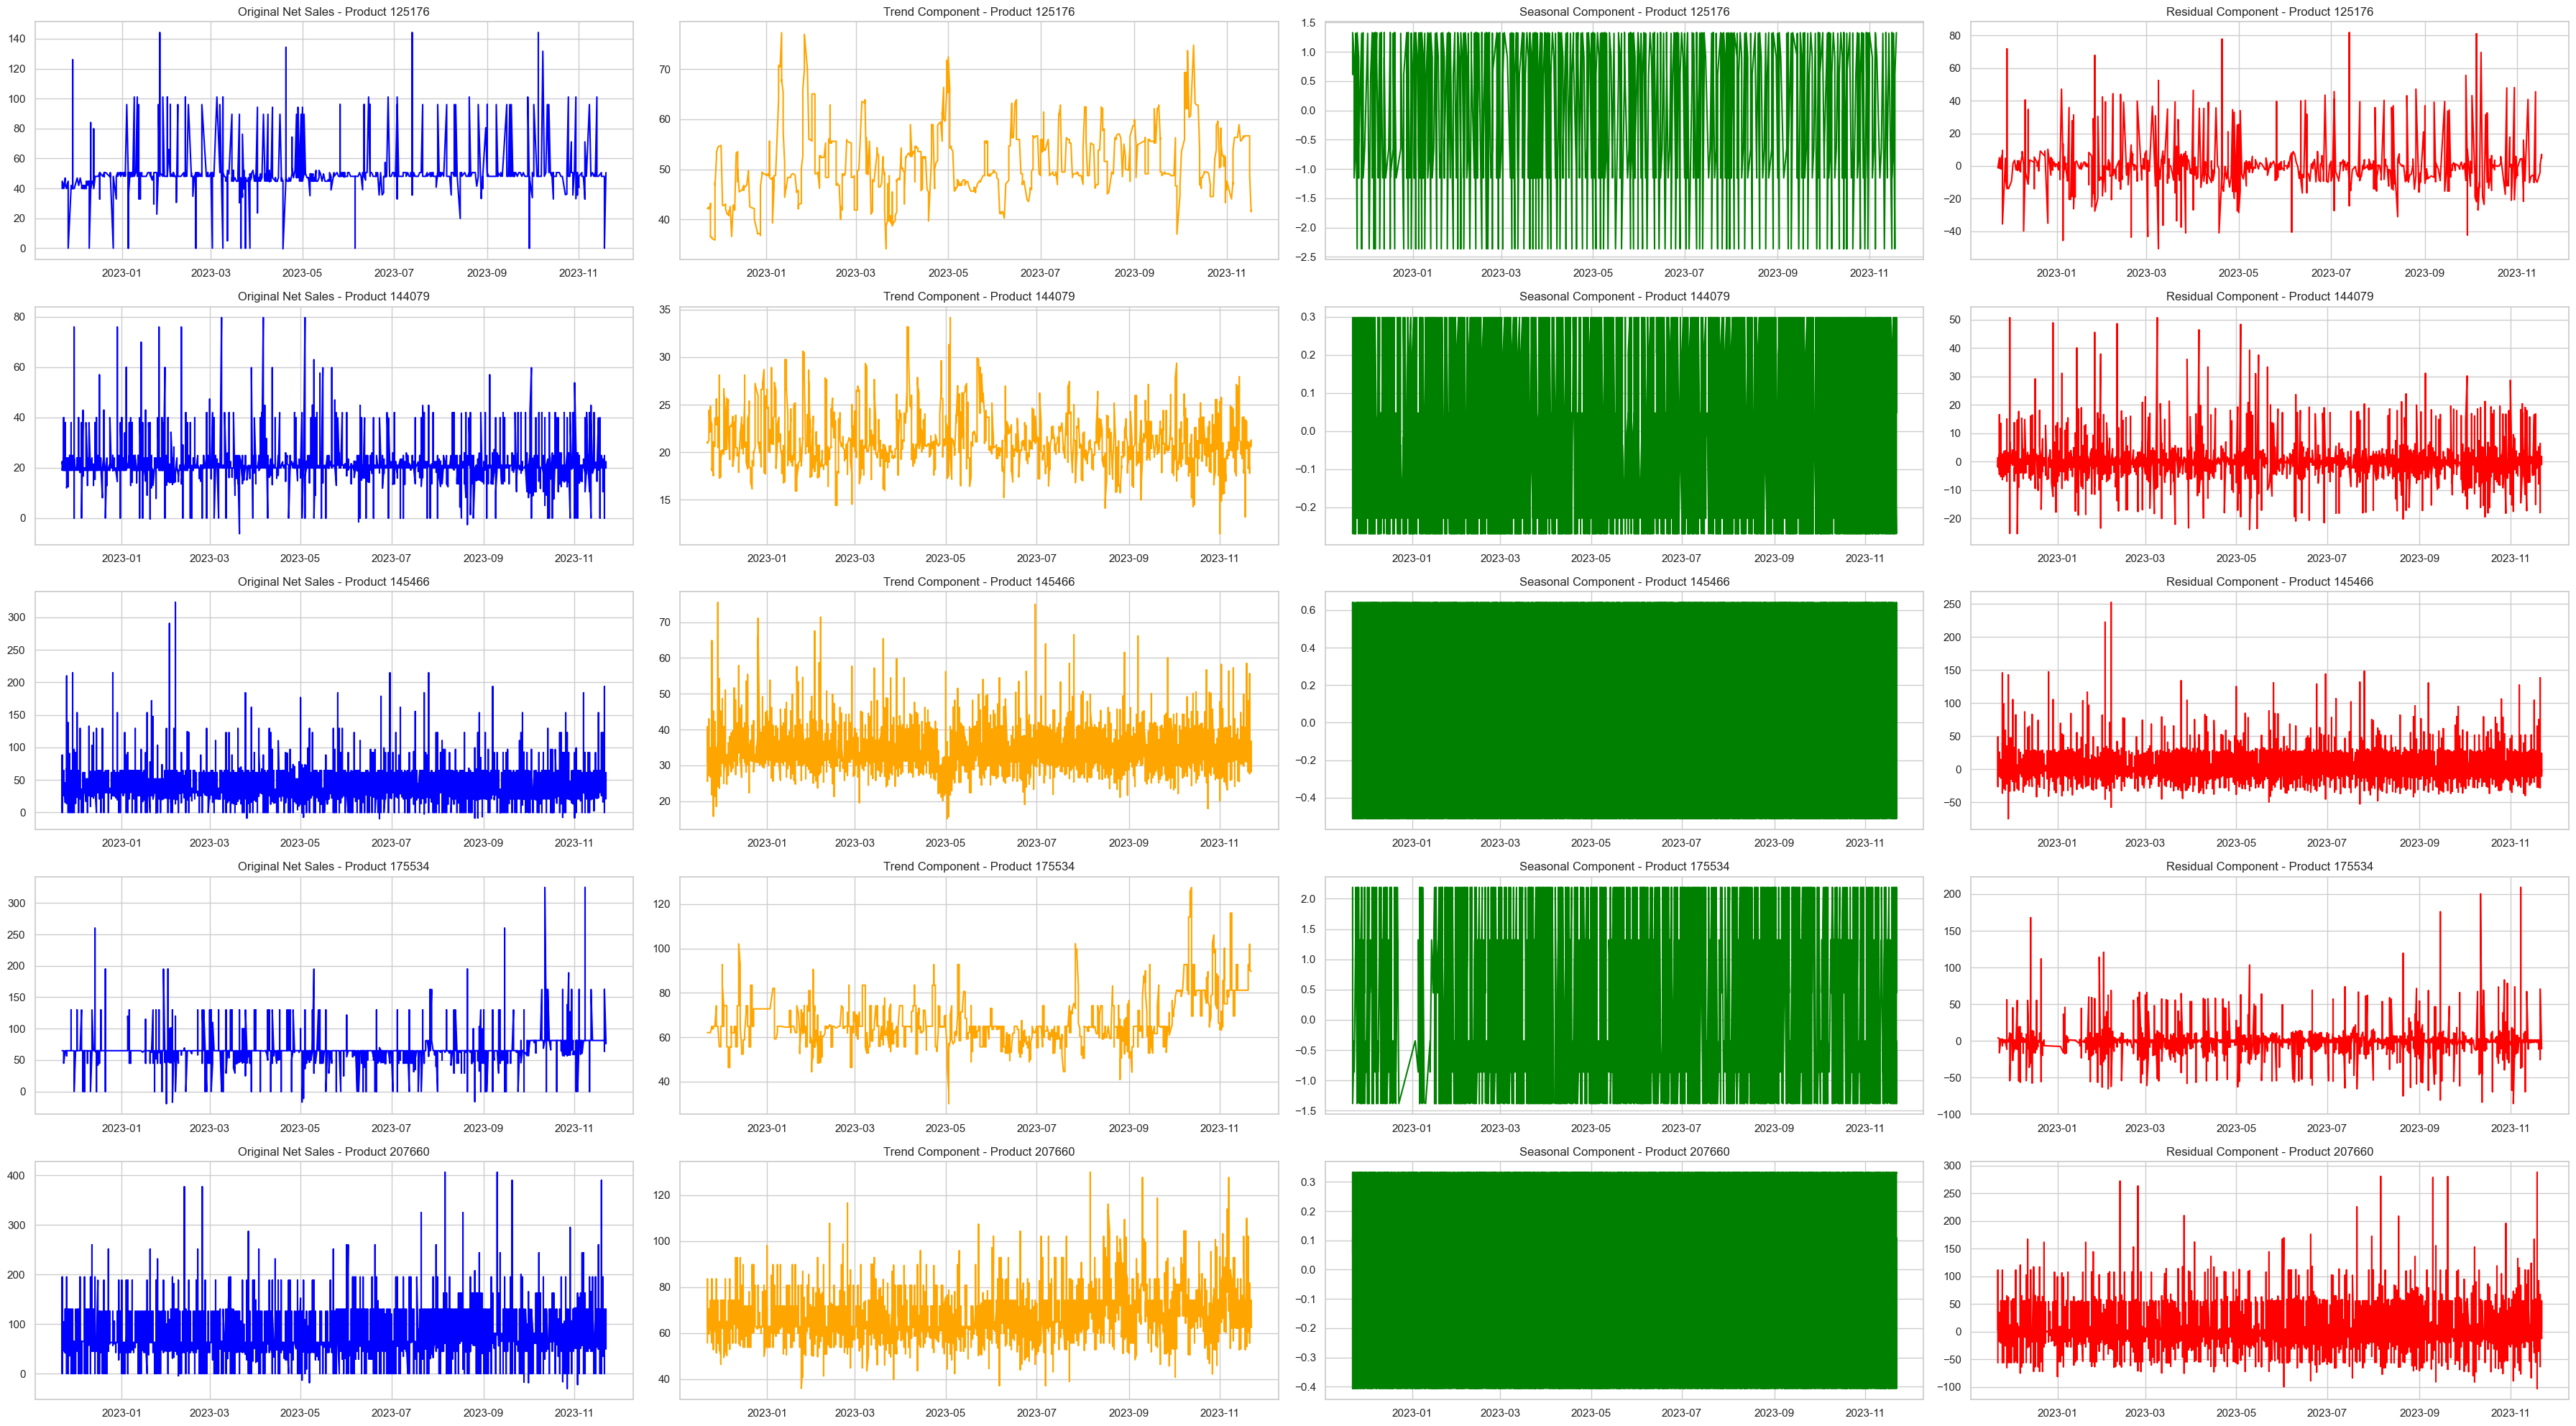

In [38]:
# Assuming that 'ORDER_PLACED_DTTM' is a datetime index, if not, convert it to datetime
subset_data.index = pd.to_datetime(subset_data.index)

# Create subplots for each PRODUCT_PART_NUMBER
unique_products = subset_data['PRODUCT_PART_NUMBER'].unique()
num_products = len(unique_products)

# Plot the decomposed components for each PRODUCT_PART_NUMBER
plt.figure(figsize=(36, 4 * num_products))

for i, product_number in enumerate(unique_products, start=1):
    product_data = subset_data[subset_data['PRODUCT_PART_NUMBER'] == product_number]['NET_SALES']

    # Decompose time series into trend, seasonal, and residual components
    result = seasonal_decompose(product_data, model='additive', period=7)
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    plt.subplot(num_products, 4, 4 * (i - 1) + 1)
    plt.plot(product_data, label='Original', color='blue')
    plt.title(f'Original Net Sales - Product {product_number}')

    plt.subplot(num_products, 4, 4 * (i - 1) + 2)
    plt.plot(trend, label='Trend', color='orange')
    plt.title(f'Trend Component - Product {product_number}')

    plt.subplot(num_products, 4, 4 * (i - 1) + 3)
    plt.plot(seasonal, label='Seasonal', color='green')
    plt.title(f'Seasonal Component - Product {product_number}')

    plt.subplot(num_products, 4, 4 * (i - 1) + 4)
    plt.plot(residual, label='Residual', color='red')
    plt.title(f'Residual Component - Product {product_number}')

plt.tight_layout()
plt.show()

### 3. Box Plots for Outlier Detection
- Use boxplots to identofy outliers in `NET_SALES` and `UNITS`

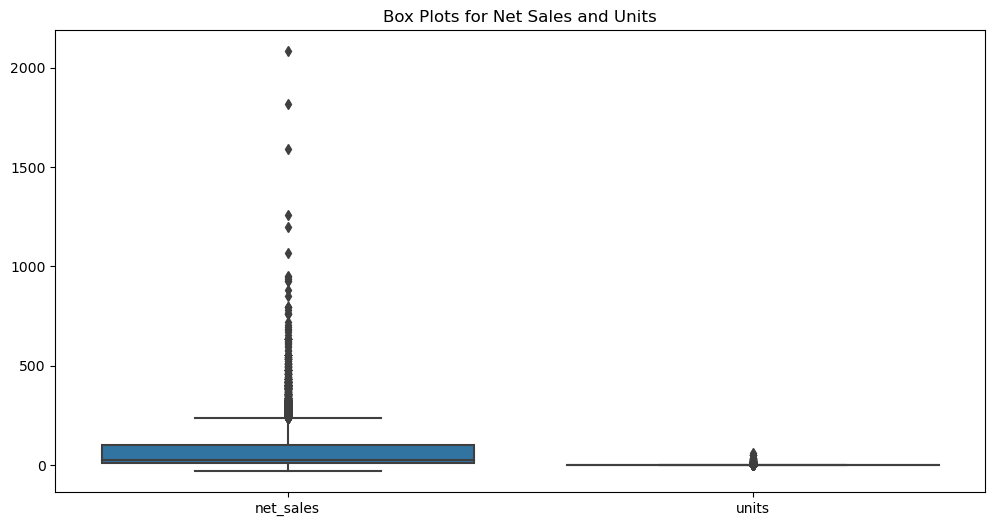

In [10]:
# Box plots for 'NET_SALES' and 'UNITS'
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['NET_SALES', 'UNITS']])
plt.title('Box Plots for Net Sales and Units')
plt.show()


In [ ]:
# Box Plots for 'NET_SALES' and 'UNITS' by group
for column in group_columns:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=column, y='NET_SALES', data=data)
    plt.title(f'Box Plots for Net Sales by {column}')
    plt.xlabel(column)
    plt.ylabel('Net Sales')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(x=column, y='UNITS', data=data)
    plt.title(f'Box Plots for Units by {column}')
    plt.xlabel(column)
    plt.ylabel('Units')
    plt.show()

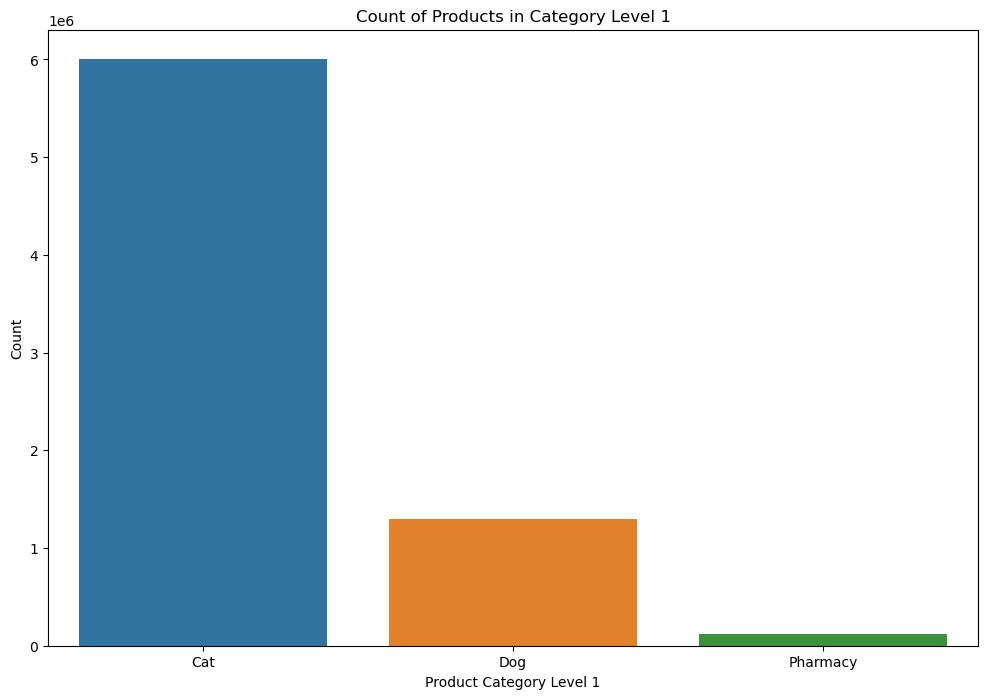

In [13]:
# Explore Categorical Features
plt.figure(figsize=(12, 8))
sns.countplot(x='PRODUCT_CATEGORY_LEVEL1', data=data)
plt.title('Count of Products in Category Level 1')
plt.xlabel('Product Category Level 1')
plt.ylabel('Count')
plt.show()


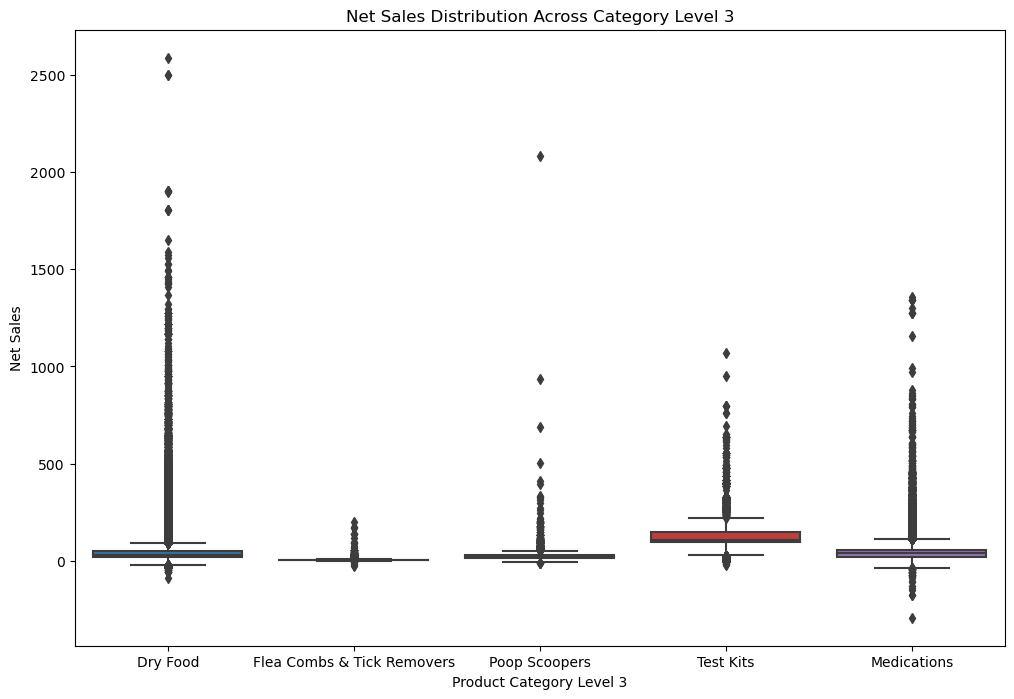

In [16]:

# Explore Relationships with Categorical Features
plt.figure(figsize=(12, 8))
sns.boxplot(x='PRODUCT_CATEGORY_LEVEL3', y='NET_SALES', data=data)
plt.title('Net Sales Distribution Across Category Level 3')
plt.xlabel('Product Category Level 3')
plt.ylabel('Net Sales')
plt.show()